<a href="https://colab.research.google.com/github/lordcj/Phoneme-Detection-using-1-Class-SVM/blob/master/New_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Any results you write to the current directory are saved as output.

In [0]:
!pip install kaldiio

  Created wheel for kaldiio: filename=kaldiio-2.15.1-cp36-none-any.whl size=22620 sha256=28d80327b34ccf80e86142f331e304700a84b67dec2e1c4d346dfbbde7eecb51
  Stored in directory: /root/.cache/pip/wheels/8a/c8/1d/a7cefe1a964c3491603fa93c4d53f25c6612636bb29feec517
Successfully built kaldiio


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import json
import kaldiio
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn import svm

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

from sklearn.svm import OneClassSVM

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle

import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [0]:
train_json_file = "kaggle/Project/input/timit/TIMIT_features/dump/train_nodev/deltafalse/data.json"
test_json_file = "kaggle/Project/input/timit/TIMIT_features/dump/test/deltafalse/data.json"
dev_json_file = "kaggle/Project/input/timit/TIMIT_features/dump/train_dev/deltafalse/data.json"

In [0]:
import os
os.chdir('/content/drive/My Drive/Competitions')

In [0]:
with open(train_json_file, 'rb') as f:
    train_json = json.load(f)['utts']
with open(test_json_file, 'rb') as f:
    test_json = json.load(f)['utts']
with open(dev_json_file, 'rb') as f:
    dev_json = json.load(f)['utts']

merged = {**train_json, **test_json, **dev_json}

In [0]:
merged

{'FAEM0_SI1392': {'input': [{'feat': '/home/neo/MS/espnet/egs/timit/asr1/dump/train_nodev/deltafalse/feats.1.ark:13',
    'name': 'input1',
    'shape': [474, 13]}],
  'output': [{'name': 'target1',
    'shape': [59, 42],
    'text': 'sil ah s uw m f aa r ih sil z ae m sil p uh l ah s ih sil ch uw ey sh n w eh er f aa r m hh eh z ah sil p ae sil k iy ng sh eh sil d sil ae n sil d f iy l sil s sil',
    'token': '<space> ah s uw m f aa r ih <space> z ae m <space> p uh l ah s ih <space> ch uw ey sh n w eh er f aa r m hh eh z ah <space> p ae <space> k iy ng sh eh <space> d <space> ae n <space> d f iy l <space> s <space>',
    'tokenid': '2 5 31 36 24 16 3 30 19 2 40 4 24 2 29 35 23 5 31 19 2 9 36 15 32 25 38 13 14 16 3 30 24 18 13 40 5 2 29 4 2 22 20 26 32 13 2 10 2 4 25 2 10 16 20 23 2 31 2'}],
  'utt2spk': 'FAEM0'},
 'FAEM0_SI2022': {'input': [{'feat': '/home/neo/MS/espnet/egs/timit/asr1/dump/train_nodev/deltafalse/feats.1.ark:6313',
    'name': 'input1',
    'shape': [223, 13]}],
  'ou

In [0]:
!wget https://raw.githubusercontent.com/sknadig/kaldi/port_aligns/egs/timit/s5/alignments -O alignments
with open("alignments", "r") as f:
    contents = f.readlines()

--2020-03-27 03:46:43--  https://raw.githubusercontent.com/sknadig/kaldi/port_aligns/egs/timit/s5/alignments
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3771623 (3.6M) [text/plain]
Saving to: ‘alignments’

alignments          100%[===================>]   3.60M  15.2MB/s    in 0.2s    

2020-03-27 03:46:44 (15.2 MB/s) - ‘alignments’ saved [3771623/3771623]



In [0]:
frame_level_dict = {}
for row in contents:
    row = row.strip().split(" ")
    uttid = row[0]
    alignments = row[1:]
    frame_level_dict[uttid] = alignments

utt_labels = frame_level_dict.values()
flat_labels = [val for sublist in utt_labels for val in sublist]

In [0]:
uniq_labels = list(sorted(set(flat_labels)))
phone_to_int = dict(zip(uniq_labels, np.arange(len(uniq_labels))))

In [0]:
def extract_features():    
    full_features = []
    full_labels = []
#     delta1=np.empty((1,vec_size))
#     delta2=np.empty((1,vec_size))
    for i, uttid in enumerate(list(frame_level_dict.keys())):
        name_change=merged[uttid]['input'][0]['feat']
        name_change=name_change.replace("/home/neo/MS/espnet/egs/timit/asr1", "kaggle/Project/input/timit/TIMIT_features")
        temp=[]
        for f in kaldiio.load_mat(name_change):
            full_features.append(f)
#             temp.append(f)
#         temp=np.array(temp)
#         t1=temp[1:]
#         lol=np.zeros([1,vec_size])
#         t1=np.vstack((t1,lol))
#         Delta=np.subtract(temp,t1)
#         delta1=np.vstack((delta1,Delta))
#         d1=Delta[1:]
#         lol=np.zeros([1,vec_size])
#         d1=np.vstack((d1,lol))
#         Delta2=np.subtract(Delta,d1)
#         delta2=np.vstack((delta2,Delta2))



        for l in np.array([phone_to_int[ele] for ele in frame_level_dict[uttid]]):
            full_labels.append(l)

    full_features = np.array(full_features)
    full_labels = np.array(full_labels)
#     delta1=delta1[1:]
#     delta2=delta2[1:]
#     full_features=np.hstack((full_features,delta1))
#     full_features=np.hstack((full_features,delta2))
    return full_features,full_labels

In [0]:
def one_hot_encoding(data):
    values = np.array(data)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [0]:
def increase_cnt(xdatafull,ydatafull,classn,countn,start_from):
    k=0
    xdata=np.empty([countn,len(full_features[0])])
    ydata=np.empty([countn,len(uniq_labels)])
    while(k<countn):
        if(ydatafull[start_from,classn]==1):
            xdata[k,:]=xdatafull[start_from,:]
            ydata[k,:]=ydatafull[start_from,:]
            k=k+1
        start_from=start_from+1
        
    
    return xdata,ydata

In [0]:
def oneClassTrainData(x_data,y_data,classn):
    k=0
    xdata=np.empty([int(sum(y_data[:,classn])),len(full_features[0])])
    ydata=np.empty([int(sum(y_data[:,classn])),len(uniq_labels)])
    for i in range(0,len(y_data)):
        if(y_data[i,classn]==1):
            xdata[k,]=x_data[i,]
            ydata[k,]=y_data[i,]
            k=k+1
    return xdata,ydata

In [0]:
def train_test_data(X_train,y_train,classn,inc_cnt):    
    X_temp,y_temp=increase_cnt(X_train_full,y_train_full,classn,inc_cnt,len(X_train))
    X_train=np.vstack ((X_train, X_temp) ) 
    y_train=np.vstack ((y_train, y_temp) ) 
    return X_train,y_train

In [0]:
!sudo pip install imbalanced-learn

In [0]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
smn = SMOTEENN(random_state=0)

In [0]:
sm = SMOTE(random_state=42)

In [0]:
tom = TomekLinks(sampling_strategy='auto')

In [0]:
def train_one_class(X_train, y_train, inc_cnt, name):
    oneClass_models = []
    score=['precision','recall']
    params_grid = [{'kernel': ['rbf'] },
                    {'kernel': ['linear']},
                   {'kernel':['poly'], 'degree' : [2,4,6,8]}
                   ]
    X_train, y_train = sm.fit_resample(X_train, y_train)
    #X_train, y_train = tom.fit_resample(X_train, y_train)
    #X_train, y_train = smn.fit_resample(X_train, y_train)
    for i in range(0,len(uniq_labels)):
        X_train1,y_train1=oneClassTrainData(X_train,y_train,i)
        print("Training Class ",i,"( ",uniq_labels[i]," )","Train count ",sum(y_train1[:,i]))#,"class count in dataset ",sum(y_test[:,i]))
        clf_oneClass = GridSearchCV(OneClassSVM(), params_grid, cv=10, scoring='f1', return_train_score=True)
        oneClass_models.append(clf_oneClass.fit(X_train1, y_train1[:,i]))
        print("Best parameters set found for ",i,"( ",uniq_labels[i]," )", " on development set: ")
        print(clf_oneClass.best_params_)
        with open(name+"oneClass_models.pckl", "wb") as f:
            for model in oneClass_models:
                 pickle.dump(model, f)

In [0]:
from imblearn.combine import SMOTEENN
smt = SMOTEENN(ratio='auto')

In [0]:
def Train_Models(X_train,y_train,inc_cnt,name):
    svm_models=[]
    oneClass_models=[]
    params_grid = [{'kernel': ['rbf']},
                    {'kernel': ['linear']},
                   {'kernel':['poly']}]
    for i in range(0,len(uniq_labels)):
        if i==5:
          continue
        X_train1,y_train1=train_test_data(X_train,y_train,i,inc_cnt)
        #X_train1, y_train1 = sm.fit_resample(X_train1, y_train1)
        trainx, trainy = X_train1[:,], y_train1[:,i]
        print("Training Class ",i,"( ",uniq_labels[i]," )","Train count ",sum(trainy), "|| Total Count ",len(trainx))#,"class count in dataset ",sum(y_test[:,i]))
        #clf = GridSearchCV(svm.SVC(C=100,probability=True), params_grid, cv=10, scoring='f1', return_train_score=True)
        clf = svm.SVC(kernel='linear',C=100,probability=True)
        svm_models.append(clf.fit(trainx,trainy))
        #print("Best parameters set found for ",i,"( ",uniq_labels[i]," )", " on development set: ")
        #print(clf.best_params_)

        #oneClass
        #X_train1,y_train1=oneClassTrainData(X_train1,y_train1,i)
        #clf_oneClass = OneClassSVM(gamma='auto')
        #oneClass_models.append(clf_oneClass.fit(X_train1))
        
    with open(name+"svm_models.pckl", "wb") as f:
        for model in svm_models:
             pickle.dump(model, f)
            
    #with open(name+"oneClass_models.pckl", "wb") as f:
    #    for model in oneClass_models:
    #         pickle.dump(model, f)

In [0]:
def Test_oneClass_Models(xdata,ydata,name):
    oneClass_models = []
    with open(name+"oneClass_models.pckl", "rb") as f:
        while True:
            try:
                oneClass_models.append(pickle.load(f))
            except EOFError:
                break
    score_oneClass=[]
    predicted_data_oneClass=np.empty([len(xdata),len(uniq_labels)])
    y_scores_oneClass=np.empty([len(xdata),len(uniq_labels)])
    for i in range(0,len(uniq_labels)):
        predicted_data_oneClass[:,i]=oneClass_models[i].predict(xdata)
        predicted_data_oneClass[:,i]=np.where(predicted_data_oneClass[:,i]==-1.0, 0,predicted_data_oneClass[:,i])
        score_oneClass.append(accuracy_score(ydata[:,i],predicted_data_oneClass[:,i]))
        y_scores_oneClass[:,i]=oneClass_models[i].decision_function(xdata)
        print("OneClass Accuracy for class ",i," = ",score_oneClass[i],"Test count :  1. ",sum(predicted_data_oneClass[:,i]),", 2. ",len(ydata)-sum(predicted_data_oneClass[:,i]))
        
    return y_scores_oneClass



In [0]:
def Test_SVM_Model(xdata,ydata,name):
    svm_models = []
    with open(name+"svm_models.pckl", "rb") as f:
        while True:
            try:
                svm_models.append(pickle.load(f))
            except EOFError:
                break
    score_svm=[]
    probabilities=np.empty([len(xdata),len(uniq_labels)])
    predicted_data_svm=np.empty([len(xdata),len(uniq_labels)])
    y_scores_svm=np.empty([len(xdata),len(uniq_labels)])
    for i in range(0,len(uniq_labels)):
      if i==5:
        continue
        predicted_data_svm[:,i]=svm_models[i].predict(xdata) # predicted class label by 2 class svm of phoneme i
        score_svm.append(accuracy_score(ydata[:,i],predicted_data_svm[:,i])) # accuracy_score returns the fraction of correctly classified samples
        y_scores_svm[:,i]=svm_models[i].decision_function(xdata) # gives on which side of the hyperplane the points are
        print("SVM Accuracy for class ",i," = ",score_svm[i],"Test count :  1. ",sum(predicted_data_svm[:,i]),", 2. ",len(ydata)-sum(predicted_data_svm[:,i]))
        pdata=svm_models[i].predict_proba(xdata) # predict probabilities of the data belonging to the particular class
        #print(pdata[:10])
        probabilities[:,i]=pdata[:,1]
        
    return y_scores_svm,probabilities

In [0]:
full_features,initial_labels=extract_features()
full_labels = one_hot_encoding(initial_labels)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(full_features, full_labels, test_size=0.2, random_state=1,stratify=full_labels)

In [0]:
def plot_rocCurve(scores,ydata):
    # Compute ROC curve and ROC AUC for each class
    n_classes = len(uniq_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    all_y_test_i = np.array([])
    all_y_predict_proba = np.array([])
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ydata[:,i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # a micro-average will aggregate the contributions of all classes to compute the average metric.
    # https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
    fpr["micro"],tpr["micro"], _ = roc_curve(ydata.ravel(), scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot each individual ROC curve
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 5], [0, 5], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right",ncol=2,fontsize="small")
    plt.show()
    return roc_auc

In [0]:
def Run_Model_one_case1(train_cnt, test_cnt, inc_cnt):
    X_train=X_train_full[:train_cnt,]
    y_train=y_train_full[:train_cnt,]
    X_test=X_test_full
    y_test=y_test_full
    name="new_case1"
    #train_test_DataCount(y_train,y_test,inc_cnt)
    train_one_class(X_train, y_train, inc_cnt, name)
    y_scores_oneClass=Test_oneClass_Models(X_test,y_test,name)
    oneClass_roc_auc=plot_rocCurve(y_scores_oneClass,y_test)
    return oneClass_roc_auc

In [0]:
def Run_Model_case1(train_cnt,test_cnt,inc_cnt):    #with appending additional train data
    X_train=X_train_full[:train_cnt,]
    y_train=y_train_full[:train_cnt,]
    X_test=X_test_full
    y_test=y_test_full
    name="new_case1"
    #train_test_DataCount(y_train,y_test,inc_cnt)
    Train_Models(X_train,y_train,inc_cnt,name)
 
    y_scores_svm,probabilities=Test_SVM_Model(X_test,y_test,name)
    #y_scores_oneClass=Test_oneClass_Models(X_test,y_test,name)

    svm_roc_auc=plot_rocCurve(y_scores_svm,y_test)
    #oneClass_roc_auc=plot_rocCurve(y_scores_oneClass,y_test)
    return svm_roc_auc,probabilities

In [0]:
one_svm_roc = Run_Model_one_case1(50000,2000,1000) #cross validation = 10 and f1 metric, tuning nu

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Training Class  0 (  aa  ) Train count  10722.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Training Class  0 (  aa  ) Train count  10722.0
Best parameters set found for  0 (  aa  )  on development set: 
{'kernel': 'linear'}
Training Class  1 (  ae  ) Train count  10722.0
Best parameters set found for  1 (  ae  )  on development set: 
{'kernel': 'linear'}
Training Class  2 (  ah  ) Train count  10722.0
Best parameters set found for  2 (  ah  )  on development set: 
{'kernel': 'linear'}
Training Class  3 (  aw  ) Train count  10722.0
Best parameters set found for  3 (  aw  )  on development set: 
{'kernel': 'linear'}
Training Class  4 (  ay  ) Train count  10722.0
Best parameters set found for  4 (  ay  )  on development set: 
{'kernel': 'linear'}
Training Class  5 (  b  ) Train count  10722.0
Best parameters set found for  5 (  b  )  on development set: 
{'kernel': 'rbf'}
Training Class  6 (  ch  ) Train count  10722.0
Best parameters set found for  6 (  ch  )  on development set: 
{'kernel': 'linear'}
Training Class  7 (  d  ) Train count  10722.0
Best parameters set found f

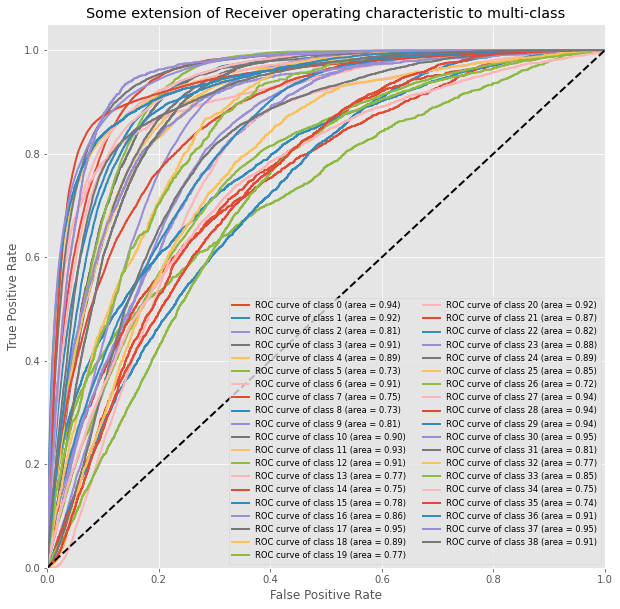

In [0]:

one_svm_roc = Run_Model_one_case1(50000,2000,1000) #cross validation = 10 and f1 metric

In [0]:
oneClass_roc_auc_c1 = one_svm_roc
conv = dict()
for key in oneClass_roc_auc_c1.keys():
    if key=='micro':
        continue
    conv[uniq_labels[int(key)]] = oneClass_roc_auc_c1[key]
df = pd.DataFrame(conv.items(), columns=['phoneme','new'])
print(df)
df.to_csv('new.csv')

   phoneme       new
0       aa  0.939068
1       ae  0.923426
2       ah  0.813701
3       aw  0.906622
4       ay  0.894470
5        b  0.729172
6       ch  0.910289
7        d  0.751399
8       dh  0.727938
9       dx  0.814822
10      eh  0.900135
11      er  0.933800
12      ey  0.914359
13       f  0.774165
14       g  0.748953
15      hh  0.782898
16      ih  0.859227
17      iy  0.948726
18      jh  0.889128
19       k  0.766386
20       l  0.922696
21       m  0.867151
22       n  0.819811
23      ng  0.884472
24      ow  0.890464
25      oy  0.853315
26       p  0.718349
27       r  0.935723
28       s  0.937465
29      sh  0.935102
30     sil  0.953017
31       t  0.806858
32      th  0.773345
33      uh  0.847988
34      uw  0.751459
35       v  0.743923
36       w  0.906870
37       y  0.946997
38       z  0.908481


In [0]:
from sklearn.metrics import SCORERS
print(sorted(SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


Training Class  0 (  aa  ) Train count  33410.0
Training Class  1 (  ae  ) Train count  20005.0
Training Class  2 (  ah  ) Train count  22474.0
Training Class  3 (  aw  ) Train count  7858.0
Training Class  4 (  ay  ) Train count  19414.0
Training Class  5 (  b  ) Train count  5942.0
Training Class  6 (  ch  ) Train count  5606.0
Training Class  7 (  d  ) Train count  6657.0
Training Class  8 (  dh  ) Train count  8805.0
Training Class  9 (  dx  ) Train count  5542.0
Training Class  10 (  eh  ) Train count  17957.0
Training Class  11 (  er  ) Train count  29125.0
Training Class  12 (  ey  ) Train count  18394.0
Training Class  13 (  f  ) Train count  17030.0
Training Class  14 (  g  ) Train count  4076.0
Training Class  15 (  hh  ) Train count  8886.0
Training Class  16 (  ih  ) Train count  41496.0
Training Class  17 (  iy  ) Train count  31762.0
Training Class  18 (  jh  ) Train count  5515.0
Training Class  19 (  k  ) Train count  16611.0
Training Class  20 (  l  ) Train count  3419

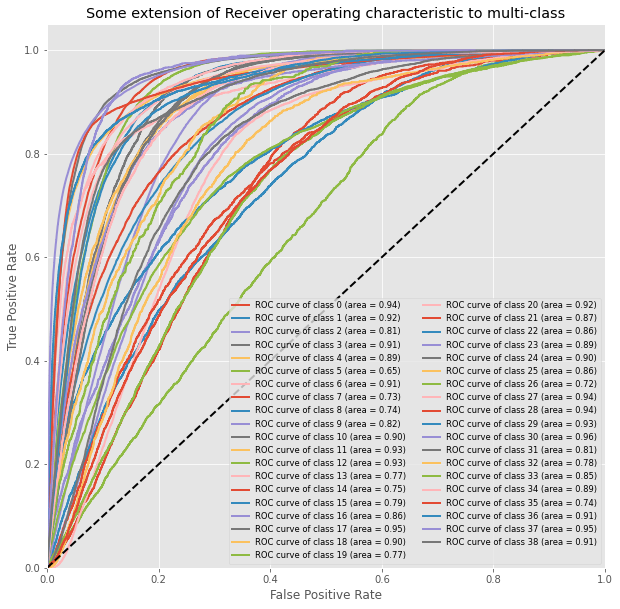

In [0]:
one_svm_roc = Run_Model_one_case1(800000,2000,1000) 

In [0]:
one_svm_roc = Run_Model_one_case1(800000,2000,1000) #using downsampling by SMOTENN

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Training Class  0 (  aa  ) Train count  168322.0
Training Class  1 (  ae  ) Train count  171730.0
Training Class  2 (  ah  ) Train count  169976.0
Training Class  3 (  aw  ) Train count  172208.0
Training Class  4 (  ay  ) Train count  171449.0
Training Class  5 (  b  ) Train count  172090.0
Training Class  6 (  ch  ) Train count  172310.0
Training Class  7 (  d  ) Train count  171958.0
Training Class  8 (  dh  ) Train count  171880.0
Training Class  9 (  dx  ) Train count  172219.0
Training Class  10 (  eh  ) Train count  171597.0
Training Class  11 (  er  ) Train count  169707.0
Training Class  12 (  ey  ) Train count  171785.0
Training Class  13 (  f  ) Train count  171618.0
Training Class  14 (  g  ) Train count  172409.0
Training Class  15 (  hh  ) Train count  172225.0
Training Class  16 (  ih  ) Train count  159542.0
Training Class  17 (  iy  ) Train count  168952.0
Training Class  18 (  jh  ) Train count  172358.0
Training Class  19 (  k  ) Train count  171569.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training Class  0 (  aa  ) Train count  2749.0
Training Class  1 (  ae  ) Train count  1510.0
Training Class  2 (  ah  ) Train count  1523.0
Training Class  3 (  aw  ) Train count  554.0
Training Class  4 (  ay  ) Train count  1483.0
Training Class  5 (  b  ) Train count  372.0
Training Class  6 (  ch  ) Train count  394.0
Training Class  7 (  d  ) Train count  428.0
Training Class  8 (  dh  ) Train count  562.0
Training Class  9 (  dx  ) Train count  415.0
Training Class  10 (  eh  ) Train count  1329.0
Training Class  11 (  er  ) Train count  2386.0
Training Class  12 (  ey  ) Train count  1375.0
Training Class  13 (  f  ) Train count  1338.0
Training Class  14 (  g  ) Train count  283.0
Training Class  15 (  hh  ) Train count  708.0
Training Class  16 (  ih  ) Train count  3097.0
Training Class  17 (  iy  ) Train count  2575.0
Training Class  18 (  jh  ) Train count  382.0
Training Class  19 (  k  ) Train count  1373.0
Training Class  20 (  l  ) Train count  2629.0
Training Class  2

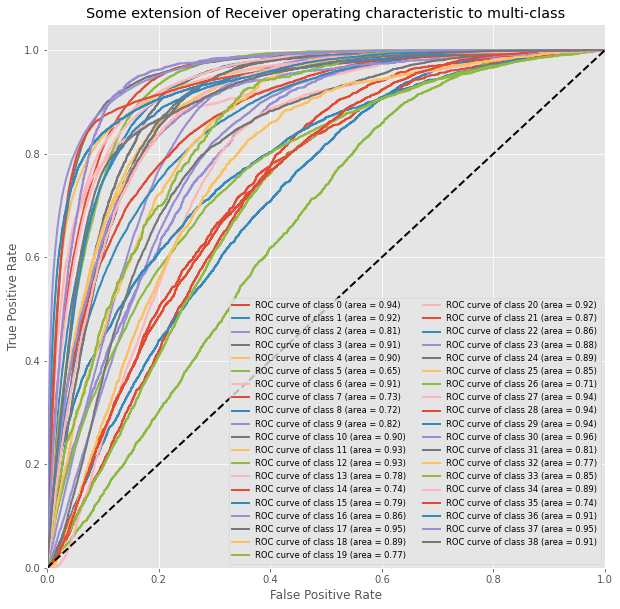

In [0]:
one_svm_roc = Run_Model_one_case1(80000,2000,1000) #using downsampling by Tomek

In [0]:
svm_roc, probabilities = Run_Model_case1(8000,2000,2000) #linear kernel

Training Class  0 (  aa  ) Train count  2347.0 || Total Count  10000
Training Class  1 (  ae  ) Train count  2171.0 || Total Count  10000
Training Class  2 (  ah  ) Train count  2245.0 || Total Count  10000
Training Class  3 (  aw  ) Train count  2082.0 || Total Count  10000
Training Class  4 (  ay  ) Train count  2188.0 || Total Count  10000
Training Class  6 (  ch  ) Train count  2058.0 || Total Count  10000
Training Class  7 (  d  ) Train count  2056.0 || Total Count  10000


In [0]:
svm_roc, probabilities = Run_Model_case1(8000,2000,2000)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Training Class  0 (  aa  ) Train count  2347 || Total Count  91533


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Training Class  1 (  ae  ) Train count  2171 || Total Count  84669


In [0]:

print(svm_roc['micro'])

NameError: ignored

In [0]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC

In [0]:
#params_grid = [{'kernel':['rbf'], 'gamma': [1e-3, 1e-4], 'C' : [1, 10, 100, 1000]}, 
#               {'kernel':['linear'], 'C': [1, 10, 100, 1000]}]

In [0]:
#svm_model = GridSearchCV(SVC(decision_function_shape = 'ovr', verbose=True), params_grid, cv=2)

In [0]:
svm_model.fit(full_features, initial_labels)

[LibSVM]

In [0]:
with open("2Class_model.pckl", "wb") as f:
        for model in oneClass_models:
             pickle.dump(model, f)

In [0]:
print(svm_model.best_estimator_)